In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import community
import numpy as np
from networkx.algorithms import cuts
import pandas as pd

# Giới thiệu về thuật toán Louvain

In [2]:
"""
Thuật toán Louvain là một trong những thuật toán phổ biến và hiệu quả để phát hiện cộng đồng trong đồ thị.
Thuật toán này dựa trên tối ưu hóa modularity (một độ đo cho chất lượng của các cộng đồng được phát hiện).

  Hoạt động như sau:

  Pha 1: Gán mỗi nút vào một cộng đồng riêng biệt
    Ban đầu, mỗi nút trong đồ thị được xem là một cộng đồng.
    Thuật toán tính toán sự thay đổi modularity khi dịch chuyển nút từ một cộng đồng sang cộng đồng khác lân cận. Nếu sự thay đổi làm tăng modularity, nút sẽ được di chuyển.

  Pha 2: Gộp các cộng đồng thành siêu nút
    Sau khi không thể cải thiện modularity, mỗi cộng đồng được gộp thành một siêu nút (super node).
    Một đồ thị mới được tạo ra, trong đó mỗi siêu nút đại diện cho một cộng đồng, và thuật toán lặp lại từ pha 1.


  + Ưu điểm:
    Tính toán nhanh, phù hợp với đồ thị lớn.
    Kết quả có modularity cao, phản ánh tốt cấu trúc cộng đồng.

  + Nhược điểm:
    Kết quả phụ thuộc vào thứ tự xử lý các nút.
    Modularité có thể không phải là độ đo hoàn hảo trong mọi trường hợp.

"""

'\nThuật toán Louvain là một trong những thuật toán phổ biến và hiệu quả để phát hiện cộng đồng trong đồ thị.\nThuật toán này dựa trên tối ưu hóa modularity (một độ đo cho chất lượng của các cộng đồng được phát hiện).\n\n  Hoạt động như sau:\n\n  Pha 1: Gán mỗi nút vào một cộng đồng riêng biệt\n    Ban đầu, mỗi nút trong đồ thị được xem là một cộng đồng.\n    Thuật toán tính toán sự thay đổi modularity khi dịch chuyển nút từ một cộng đồng sang cộng đồng khác lân cận. Nếu sự thay đổi làm tăng modularity, nút sẽ được di chuyển.\n\n  Pha 2: Gộp các cộng đồng thành siêu nút\n    Sau khi không thể cải thiện modularity, mỗi cộng đồng được gộp thành một siêu nút (super node).\n    Một đồ thị mới được tạo ra, trong đó mỗi siêu nút đại diện cho một cộng đồng, và thuật toán lặp lại từ pha 1.\n\n\n  + Ưu điểm:\n    Tính toán nhanh, phù hợp với đồ thị lớn.\n    Kết quả có modularity cao, phản ánh tốt cấu trúc cộng đồng.\n\n  + Nhược điểm:\n    Kết quả phụ thuộc vào thứ tự xử lý các nút.\n    Modul



---

## 3. Tóm tắt tổng quan các chỉ số đánh giá việc phát hiện cộng đồng

### 1. **Modularity**
Công thức:

\[
Q = \frac{1}{2m} \sum_{i,j} \left( A_{ij} - \frac{k_i k_j}{2m} \right) \delta(c_i, c_j)
\]

Trong đó:
- \( A_{ij} \): Trọng số giữa nút \( i \) và \( j \).
- \( k_i, k_j \): Bậc (degree) của các nút \( i \) và \( j \).
- \( m \): Tổng trọng số các cạnh trong đồ thị.
- \( \delta(c_i, c_j) \): Bằng 1 nếu nút \( i \) và \( j \) trong cùng cộng đồng; ngược lại bằng 0.

**Phạm vi**: \([-0.5, 1]\)

**Như thế nào là tốt**: **Modularity** càng cao thì cộng đồng càng tách biệt. Giá trị trên 0.3 thường được xem là tốt.

---

### 2. **Conductance**
Công thức:

\[
\phi(S) = \frac{\text{edges exiting } S}{\min(\text{edges within } S, \text{edges outside } S)}
\]

Trong đó:
- \( S \) là một cộng đồng.

**Phạm vi**: \([0, 1]\)

**Như thế nào là tốt**: Giá trị nhỏ hơn thể hiện cộng đồng tốt hơn (ít cạnh cắt hơn).

---

### 3. **Normalized Cut**
Công thức:

\[
NC(S) = \frac{\text{edges exiting } S}{\text{total edges incident to } S}
\]

**Phạm vi**: \([0, 1]\)

**Như thế nào là tốt**: Giá trị nhỏ thể hiện cộng đồng tách biệt rõ ràng.

---

### 4. **Số lượng cộng đồng (Num Communities)**

**Ý nghĩa**:
- Số lượng cộng đồng giúp đánh giá mức độ phân cụm của đồ thị.
- Quá ít hoặc quá nhiều cộng đồng đều không lý tưởng.


In [3]:
import networkx as nx
import numpy as np
import pandas as pd

class CommunityMetrics:
    def __init__(self, graph, partitions):
        """
        :param graph: Đồ thị (NetworkX graph).
        :param partitions: Dictionary với khóa là thuật toán (tên) và giá trị là danh sách các cụm (list of sets).
        """
        self.graph = graph
        self.partitions = partitions
        self.metrics_df = None

    def calculate_modularity(self, partition):
        """
        Tính Modularity cho danh sách các cụm.
        """
        modularity = nx.algorithms.community.quality.modularity(self.graph, partition)
        return modularity

    def calculate_conductance(self, partition):
        """
        Tính Conductance cho danh sách các cụm.
        """
        conductances = [nx.algorithms.cuts.conductance(self.graph, comm) for comm in partition]
        return np.mean(conductances)

    def calculate_normalized_cut(self, partition):
        """
        Tính Normalized Cut cho danh sách các cụm.
        """
        normalized_cuts = [nx.algorithms.cuts.normalized_cut_size(self.graph, comm) for comm in partition]
        return np.mean(normalized_cuts)

    def calculate_metrics(self):
        """
        Tính toán tất cả các chỉ số đánh giá cho mỗi thuật toán phát hiện cộng đồng.
        """
        metrics_data = []

        for algorithm, partition in self.partitions.items():
            modularity = self.calculate_modularity(partition)
            conductance = self.calculate_conductance(partition)
            normalized_cut = self.calculate_normalized_cut(partition)
            num_communities = len(partition)

            metrics_data.append({
                'Algorithm': algorithm,
                'Modularity': modularity,
                'Conductance': conductance,
                'Normalized Cut': normalized_cut,
                'Num Communities': num_communities
            })

        self.metrics_df = pd.DataFrame(metrics_data)
        return self.metrics_df

    def display_metrics(self):
        """
        Hiển thị các chỉ số đánh giá trong bảng.
        """
        if self.metrics_df is not None:
            print(self.metrics_df)
        else:
            print("No metrics calculated yet.")

# # Ví dụ sử dụng:
# if __name__ == "__main__":
#     # Tạo đồ thị ví dụ (Karate Club Graph)
#     graph = nx.karate_club_graph()

#     # Các cụm ví dụ (giả sử đã được phát hiện bởi các thuật toán)
#     partitions = {
#         'Girvan-Newman': [{0, 1, 2, 3}, {4, 5, 6}, {7, 8, 9}],
#         'Label Propagation': [{0, 1, 2, 3, 4}, {5, 6, 7, 8, 9}],
#         'Louvain': [{0, 1, 2}, {3, 4, 5, 6}, {7, 8, 9}]
#     }

#     # Khởi tạo lớp và tính toán chỉ số
#     metrics_calculator = CommunityMetrics(graph, partitions)
#     metrics_df = metrics_calculator.calculate_metrics()

#     # Hiển thị các chỉ số
#     metrics_calculator.display_metrics()

# Phân tích mạng xã hội

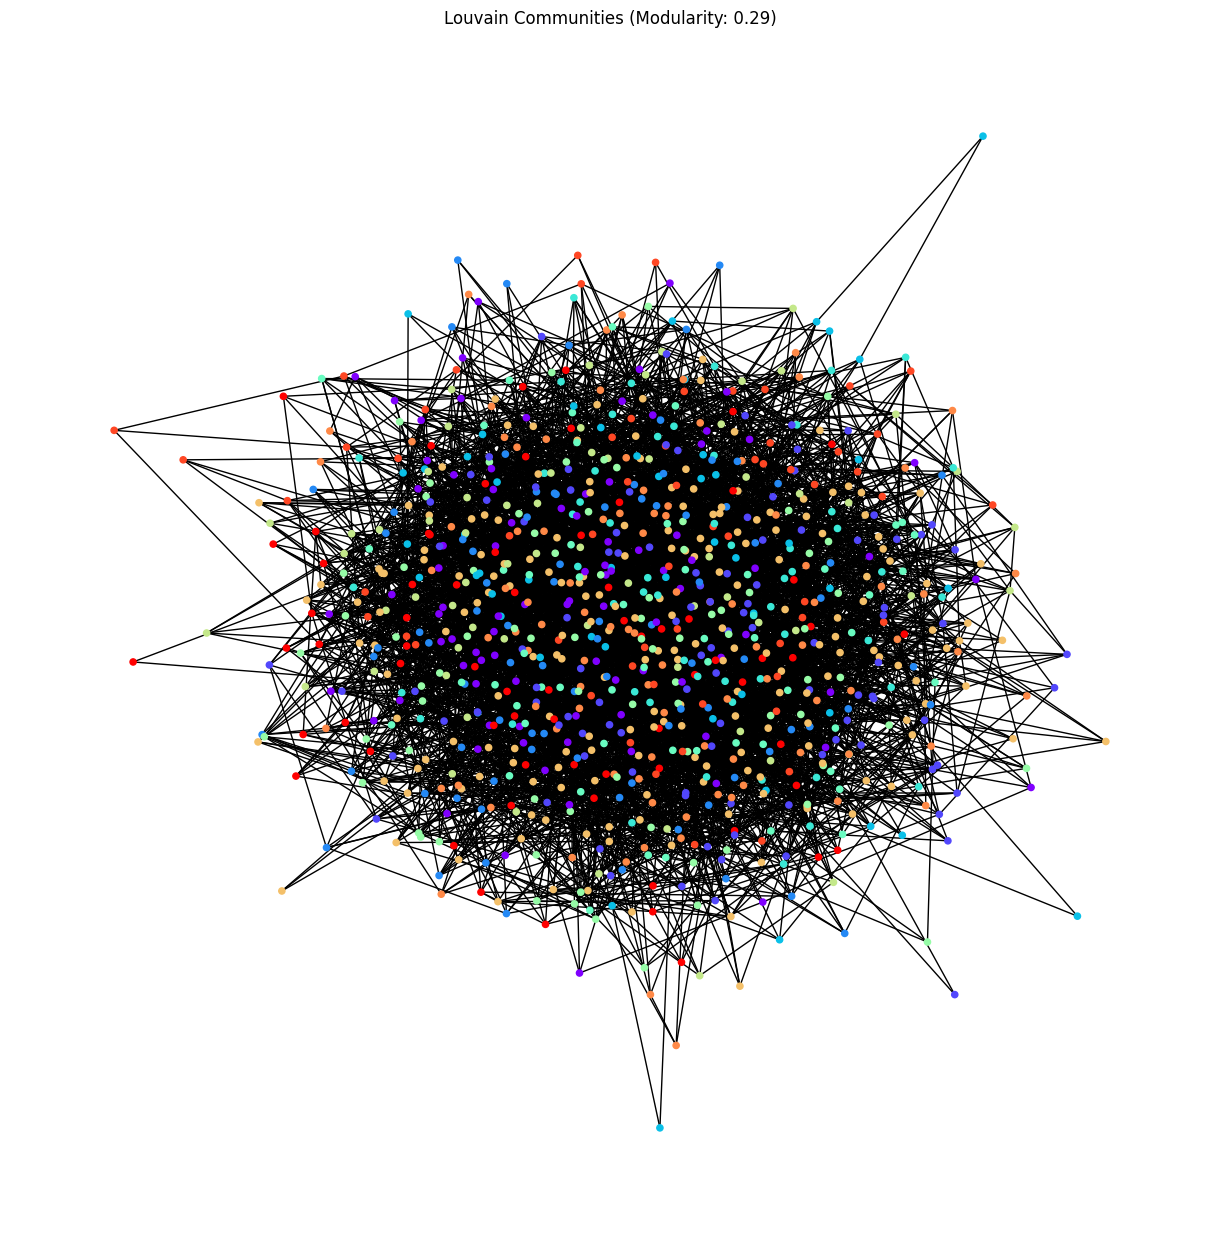

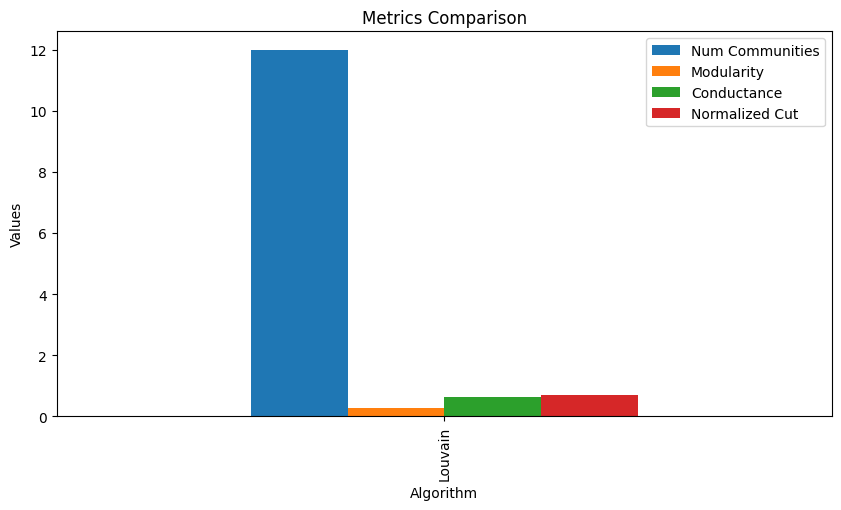

In [4]:
import networkx as nx
from networkx.algorithms import community
from networkx.algorithms.cuts import conductance, normalized_cut_size
import pandas as pd
import matplotlib.pyplot as plt

# Tạo đồ thị ngẫu nhiên Erdős–Rényi với 1000 nút và xác suất cạnh p = 0.01
G = nx.erdos_renyi_graph(1000, 0.01)

class CommunityAnalysis:
    def __init__(self, graph):
        self.graph = graph
        self.partitions = {}
        self.metrics_df = None

    def detect_communities(self):
        # Louvain
        self.partitions['Louvain'] = list(community.louvain_communities(self.graph))

    def calculate_metrics(self):
        def calculate_for_partition(partition):
            return {
                'Num Communities': len(partition),
                'Modularity': community.modularity(self.graph, partition),
                'Conductance': sum(conductance(self.graph, c) for c in partition) / len(partition),
                'Normalized Cut': sum(normalized_cut_size(self.graph, c) for c in partition) / len(partition)
            }

        metrics = calculate_for_partition(self.partitions['Louvain'])
        metrics['Algorithm'] = 'Louvain'
        self.metrics_df = pd.DataFrame([metrics])

    def visualize_communities(self):
        pos = nx.spring_layout(self.graph)
        modularity = community.modularity(self.graph, self.partitions['Louvain'])

        # Gán màu cho các nút
        colors = []
        for node in self.graph.nodes():
            for i, comm in enumerate(self.partitions['Louvain']):
                if node in comm:
                    colors.append(i)

        # Vẽ đồ thị
        plt.figure(figsize=(12, 12))
        nx.draw(self.graph, pos, node_color=colors, with_labels=False, node_size=20, cmap=plt.cm.rainbow)
        plt.title(f"Louvain Communities (Modularity: {modularity:.2f})")
        plt.show()

    def plot_metrics(self):
        metrics = self.metrics_df
        metrics.set_index('Algorithm').plot(kind='bar', figsize=(10, 5))
        plt.title("Metrics Comparison")
        plt.ylabel("Values")
        plt.show()


# Thực thi phân tích
analysis = CommunityAnalysis(G)
analysis.detect_communities()
analysis.calculate_metrics()
analysis.visualize_communities()
analysis.plot_metrics()
